# Regularization: The Lab

Highest AUC gets to pick a sticker from the sticker skull.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

import sklearn.linear_model, sklearn.preprocessing, sklearn.metrics

from tqdm import tqdm
from IPython.core.pylabtools import figsize

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Load and prepare the data

In [2]:
data = pd.read_csv("titanic.csv")
len(data)

1309

In [3]:
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [4]:
# shamelessly stolen from the titanic lab- build features
data = data.drop(["boat", "body", "home.dest", "cabin", "name"], axis=1)
data = data.dropna()
data["gender"] = data["sex"].map({"female":0, "male":1}).astype(int)
embark_dummies = pd.get_dummies(data['embarked'], prefix='embarked')
data = pd.concat([data, embark_dummies], axis=1)
# split into features and labels
X = data[["pclass", "age", "sibsp", "parch", "fare", "gender", "embarked_C", "embarked_Q", "embarked_S"]]
Y = data.survived
# split into train/test
np.random.seed(1)
split = np.random.choice([True, False], p=[0.7, 0.3], size=len(data))
X_train = X[split].values
X_test = X[~split].values
Y_train = Y[split].values
Y_test = Y[~split].values

### Split into batches

Remember that the number of batches you split the data into will change how the model trains!

You can do all the data at once, break into large or small batches, and choose whether to split them once or reshuffle every training epoch.

Here's some example code that will (every time you call it) reshuffle the dataset and generate a new list of `(training_points, training_labels)` tuples.

In [5]:
def batchinator(num_batches=5):
    N = X_train.shape[0]
    # shuffle the order
    ordering = np.random.choice(np.arange(N), replace=False, size=N)
    train_batches = np.array_split(X_train[ordering,:], num_batches, axis=0)
    train_label_batches = np.array_split(Y_train[ordering], num_batches)
    return zip(train_batches, train_label_batches)

## Build a model

The built-in tensorflow estimators don't actually have all the bells and whistles we want- so let's scavenge pieces from last week's code example and roll our own. Modify the model however you like. Follow your dreams.

### Model details

The code below is for a multilayer perceptron with a single hidden layer. Some basic parameters you can mess with:

* the number of hidden-layer neurons
* the hidden-layer activation function (I picked sigmoid, but you could do tanh, ReLU, etc)
* the optimizer to use for training (I picked SGD with momentum, but you could do vanilla SGD, ADAM, RMSprop...) and its associated parameters
* how the learning rate changes as you train- I added a `tf.placeholder_with_default` so (if you want) you can decrease the rate during training.

### Regularization options

* `epsilon` add noise to weights during training
* `lambda_1` $L_{1}$ norm regularization strength
* `lambda_2` $L_{2}$ norm regularization strength
* `dropout` we haven't talked about dropout regularization yet, but it's really cool. Try setting to 0.5. Note that it will roughly double the number of training epochs required.

In [8]:
tf.reset_default_graph()

# MODEL PARAMETERS
input_dim = X.shape[1]
num_hidden = 25
num_classes = 2
learnrate = 0.01
momentum = 0.9


# REGULARIZATION PARAMETERS
epsilon = 0.1   # add "dithering" noise to weights
lambda_1 = 1e-5 # L1 norm regularization weight
lambda_2 = 1e-5 # L2 norm regularization weight
dropout = 1.0   # dropout probability

# INPUT LAYER
x = tf.placeholder(tf.float32, [None, input_dim], name="data_placeholder")
y_ = tf.placeholder(tf.int32, [None,], name="label_placeholder")
is_training = tf.placeholder_with_default(1., []) 
y_oh = tf.one_hot(y_, num_classes, name="labels_one_hot")

# HIDDEN LAYER
W1 = tf.Variable(tf.random_normal([input_dim, num_hidden], 0, 0.01))
noise1 = is_training*tf.random_normal([input_dim, num_hidden], 0, epsilon)
b1 = tf.Variable(tf.zeros([num_hidden]))
y1 = tf.matmul(x,W1+noise1) + b1    
#hidden = tf.sigmoid(y1) # or use tf.nn.relu(y1) or tf.nn.tanh(y1) here if you prefer
if dropout < 1.0:
    # set probability to 0.5 if training and 1 if evaluating
    drop = is_training*dropout + (1-is_training)
    y1 = tf.nn.dropout(y1, drop)
hidden = tf.nn.tanh(y1)

# OUTPUT LAYER
W2 = tf.Variable(tf.random_normal([num_hidden, num_classes], 0, 0.01))
noise2 = is_training*tf.random_normal([num_hidden, num_classes], 0, epsilon)   
b2 = tf.Variable(tf.zeros([num_classes]))
y2 = tf.matmul(hidden,W2+noise2) + b2   
output = tf.sigmoid(y2)

# LOSS FUNCTION
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_oh, logits=y2))
l2_loss = tf.reduce_sum(W1**2) + tf.reduce_sum(W2**2)
l1_loss = tf.reduce_sum(tf.abs(W1)) + tf.reduce_sum(tf.abs(W2))
loss = cross_entropy + lambda_1*l1_loss + lambda_2*l2_loss

# TRAINING OPERATION

learnrate_ph = tf.placeholder_with_default(learnrate, ())
# feel free to use a different optimizer from tf.train.
optimizer = tf.train.MomentumOptimizer(learnrate_ph, momentum) 
train_step = optimizer.minimize(cross_entropy)

# PREDICTIONS AND PERFORMANCE MEASURES
prediction = tf.argmax(y2,1)
correct_prediction = tf.equal(prediction, tf.argmax(y_oh,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Training the model

Nothing fancy here- start a session, initialize your variables, and start a training loop. I've included some code to measure test accuracy once per epoch and then plot at the end.

The `tf.train.Saver()` object can write the session to disk so we can pull it up later for inference.

100%|██████████| 2000/2000 [00:09<00:00, 208.87it/s]


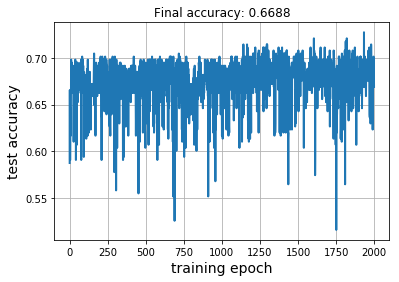

In [9]:
numsteps = 2000
num_batches = 5
# create an empty array to hold test accuracy at each step
test_acc = np.zeros(numsteps)
saver = tf.train.Saver()

# create a session to run in
with tf.Session() as sess:
    # initialize variables
    sess.run(tf.global_variables_initializer())
    # for each training step
    for i in tqdm(range(numsteps)):
        # for each batch
        for x_batch,y_batch in batchinator(num_batches):
            # build a feed_dict
            fd = {x:x_batch, y_:y_batch,
                 is_training:1,
                 learnrate_ph:learnrate}
            sess.run(train_step, feed_dict=fd)
        # once per epoch check the test accuracy
        test_acc[i] = sess.run(accuracy, 
                            feed_dict={x:X_test,y_:Y_test,
                                    is_training:0})
    # save session in case we need it later
    saver.save(sess, "logs/model.ckpt")
    
plt.plot(test_acc, lw=2)
plt.grid("on")
plt.xlabel("training epoch", fontsize=14)
plt.ylabel("test accuracy", fontsize=14)
plt.title("Final accuracy: %s"%round(test_acc[-1],4));

## Inference

Here's how to load the session back and re-run the model on a new dataset:

In [10]:
with tf.Session() as sess:
    saver.restore(sess, "logs/model.ckpt")
    predictions = sess.run(output, feed_dict={x:X_test})[:,1]

INFO:tensorflow:Restoring parameters from logs/model.ckpt
